# Lesson 10: Free Recall

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2022_Fall/notebooks/10_Free_Recall.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Discuss free recall variants
- Load and process some free recall data
- Visualize basic results
- Introduce SAM and TCM models
- Fit single subject to both
- Show overall results (from cluster)

## How can we test episodic memory?

- **Free recall**
  - Study a list of items and then recall them in any order you like
- **Serial recall**
  - Study a list of items and then recall them in a specific order
- **Cued recall**
  - Study pairs of items and recall one item when cued with the other
- **Item recognition**
  - Study a list of items and then identify studied vs. novel items
- **Associative recognition**
  - Study pairs of items and then identify studied vs. novel (new or rearranged) items
- **Judgment of recency**
  - Study items and then identify which of two items occurred more recently


## Let's explore the data!!!

In [ ]:
# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git --upgrade


## *ONLY* if on Google Colab

In [ ]:
# to install more libraries
!pip install KDEpy
!pip install arviz

## Load modules of power

In [70]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

import arviz as az
from sklearn.preprocessing import OneHotEncoder

from RunDEMC import Model, Param, dists, calc_bpic, joint_plot
from RunDEMC.io import arviz_dict, save_results, load_results
from RunDEMC import Hierarchy, HyperPrior, NormalHyperPrior

from joblib import Parallel, delayed

import os
from glob import glob

import banal as ba
from ci_within import ci_within


# Free Recall

## General Structure

### Immediate Free Recall (IFR)

`STUDY list (16 items)` -> `Free Recall (60 sec)`

### Delayed Free Recall (DFR)

`STUDY list (16 items)` -> `MATH distractor (20 sec)` -> `Free Recall (60 sec)`

### Continual Distractor Free Recall (CDFR)

`MATH distractor (20 sec)` -> `STUDY Item` -> 
`MATH distractor (20 sec)` -> `STUDY Item` -> 
`MATH distractor (20 sec)` -> `STUDY Item` -> 
`MATH distractor (20 sec)` -> `STUDY Item` ->
...
`MATH distractor (20 sec)` -> `STUDY Item` -> 
`MATH distractor (20 sec)` -> `STUDY Item` -> 
`MATH distractor (20 sec)` -> `Free Recall (60 sec)`

## Core Premise

*What you recall, and the order in which you recall it, can inform the associative processes used to guide episodic memory retrieval.*

## Load in the data

In [5]:
# get list of all files
files = glob('ltp/*')

In [72]:
def load_subj_data(filename):
    subj = filename.split('/')[-1].split('_')[-1].split('.mat')[0]
    
    x = ba.proc_mat_subj(filename)

    masks = {}
    masks[0] = ((x['distractor'] == 0) & (x['final_distractor'] == 0))
    masks[1] = ((x['distractor'] == 0) & (x['final_distractor'] == 8000))
    masks[2] = ((x['distractor'] == 0) & (x['final_distractor'] == 16000))
    masks[3] = ((x['distractor'] == 8000) & (x['final_distractor'] == 8000))
    masks[4] = ((x['distractor'] == 16000) & (x['final_distractor'] == 16000))

    recalls_IFR = x['recalls'][masks[0]]
    #recalls_DFR = x['recalls'][masks[1] | masks[2]]
    recalls_DFR = x['recalls'][masks[2]]
    #recalls_CDFR = x['recalls'][masks[3] | masks[4]]
    recalls_CDFR = x['recalls'][masks[4]]

    listlen = x['listlen']

    obs_recalls = {'IFR': recalls_IFR, 
                   'DFR': recalls_DFR, 
                   'CDFR': recalls_CDFR}
    # obs_recalls = {'IFR': recalls_IFR}
    for lt in obs_recalls:
        mask = np.sum(obs_recalls[lt]>=1, axis=1)>3
        obs_recalls[lt] = obs_recalls[lt][mask, :]

        these_recalls = []
        for i in range(obs_recalls[lt].shape[0]):
            lx = list(obs_recalls[lt][i][obs_recalls[lt][i]>=1])
            # NOTE ADDITION of pandas unique call to remove repeats
            these_recalls.append(pd.unique(lx))
        obs_recalls[lt] = ba.apply_to_zeros(these_recalls)
        
    return subj, obs_recalls, listlen
    
subj, obs_recalls, listlen = load_subj_data(filename)

In [73]:
obs_recalls

{'IFR': array([[16, 10, 12, 15,  1,  2,  3,  4,  6,  7,  9,  8, 11,  0,  0],
        [15, 16, 12, 11,  6,  7,  1,  3,  2,  5,  9,  8, 13,  0,  0],
        [15, 16, 10, 11,  3,  7,  4,  9,  8,  5,  2,  1,  0,  0,  0],
        [15, 16,  1, 14,  2,  3,  7,  5,  4,  6, 11,  8,  9, 12,  0],
        [ 9, 10,  8, 16,  6,  2,  1, 14, 13, 12,  3,  4,  5,  0,  0],
        [15, 16, 13, 11,  5,  6,  9,  8,  1,  2,  3,  4,  0,  0,  0],
        [16, 15, 12, 13,  4,  2,  1,  3,  5,  0,  0,  0,  0,  0,  0],
        [14, 15, 16,  7, 12,  6,  1,  2,  5, 13,  4,  3,  0,  0,  0],
        [16, 11, 14, 13,  5,  1,  7,  3,  6,  8, 10,  0,  0,  0,  0],
        [13, 14, 15, 16,  6,  7,  8,  9, 11,  4,  2,  1,  5,  0,  0],
        [15, 16, 10, 11,  7, 13,  6,  2,  4,  3,  5,  1, 14,  0,  0],
        [16, 14,  8,  7,  4,  3,  2,  1,  5,  6, 10,  0,  0,  0,  0],
        [ 9, 16, 11,  8, 12,  7,  3,  4,  2,  1, 10,  0,  0,  0,  0],
        [16, 13,  7,  2,  1, 12,  4,  3,  5,  6,  8,  0,  0,  0,  0],
        [ 3, 

## Load and process data

In [80]:
rdict_spc = {'subj': [], 'cond': [], 'serial_pos': [], 'prec': []}
rdict_crp = {'subj': [], 'cond': [], 'lag': [], 'crp': []}

for filename in files:
    # load in their data
    subj, obs_recalls, listlen = load_subj_data(filename)
    print(subj, end=' ')
    
    # calc spc
    for c in ['IFR','DFR', 'CDFR']:
        res = ba.spc(listlen=listlen, recalls=obs_recalls[c])
        rdict_spc['subj'].extend([subj]*len(res['serial_pos']))
        rdict_spc['cond'].extend([c]*len(res['serial_pos']))
        rdict_spc['serial_pos'].extend(list(res['serial_pos']))
        rdict_spc['prec'].extend(list(res['prec']))
        #plt.plot(res['serial_pos'], res['prec'], 'o-')
        
    # calc crp
    for c in ['IFR','DFR', 'CDFR']:
        res = ba.crp(listlen=listlen, recalls=obs_recalls[c])
        rdict_crp['subj'].extend([subj]*len(res['lag']))
        rdict_crp['cond'].extend([c]*len(res['lag']))
        rdict_crp['lag'].extend(list(res['lag']))
        rdict_crp['crp'].extend(list(res['crp']))
        #plt.plot(res['lag'], res['crp'])
df_spc = pd.DataFrame(rdict_spc)
df_crp = pd.DataFrame(rdict_crp)
df_crp.head()

LTP232 LTP147 LTP076 LTP256 LTP259 LTP285 LTP117 LTP085 LTP246 LTP150 LTP153 LTP105 LTP195 LTP088 LTP254 LTP110 LTP268 LTP151 LTP174 LTP191 LTP260 LTP198 LTP104 LTP199 LTP140 LTP064 LTP128 LTP265 LTP138 LTP073 LTP081 LTP197 LTP193 LTP090 LTP275 LTP211 LTP125 LTP272 LTP106 LTP079 LTP082 LTP074 

,subj,cond,lag,crp
0,LTP232,IFR,-15,0.066667
1,LTP232,IFR,-14,0.040000
2,LTP232,IFR,-13,0.000000
3,LTP232,IFR,-12,0.026316
4,LTP232,IFR,-11,0.000000


## Serial Position Curve

In [99]:
res_spc = ci_within(df_spc, indexvar='subj', 
                    withinvars=['cond', 'serial_pos'], 
                    measvar='prec').reset_index()
res_spc.head()

,cond,serial_pos,mean,std,sem,ci,len
0,CDFR,1,0.665346,0.254412,0.039257,0.079280,42
1,CDFR,2,0.657760,0.269520,0.041588,0.083988,42
2,CDFR,3,0.622211,0.267367,0.041256,0.083318,42
3,CDFR,4,0.626675,0.247919,0.038255,0.077257,42
4,CDFR,5,0.594024,0.259327,0.040015,0.080812,42


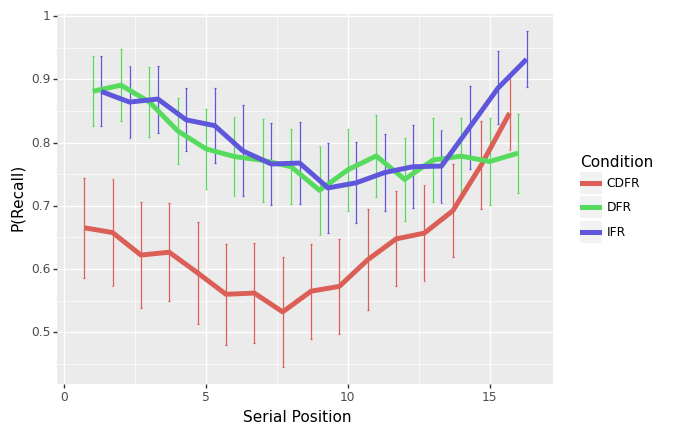

<ggplot: (8781391085014)>

In [95]:
import plotnine as pn

p = (pn.ggplot(res_spc, pn.aes('serial_pos', 'mean', fill='cond', color='cond'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.9))
     #+ pn.geom_point(position=pn.position_dodge(.9), size=4)
     + pn.geom_line(position=pn.position_dodge(.9), size=2)
     + pn.labs(x="Serial Position", y = "P(Recall)", color='Condition')
    )
p



In [100]:
res_crp = ci_within(df_crp, indexvar='subj', 
                    withinvars=['cond', 'lag'], 
                    measvar='crp').reset_index()
res_crp.head()

,cond,lag,mean,std,sem,ci,len
0,CDFR,-15,0.066540,0.091332,0.014093,0.028461,42
1,CDFR,-14,0.040012,0.071899,0.011094,0.022405,42
2,CDFR,-13,0.033055,0.062308,0.009614,0.019417,42
3,CDFR,-12,0.041181,0.063232,0.009757,0.019704,42
4,CDFR,-11,0.056541,0.095554,0.014744,0.029777,42


/home/per/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_errorbar : Removed 3 rows containing missing values.


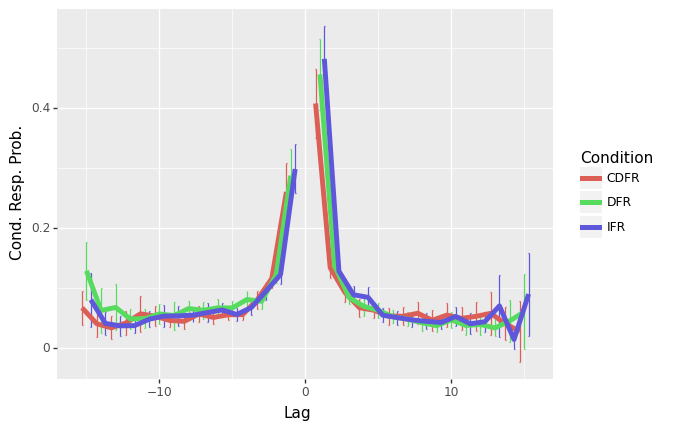

<ggplot: (8781391041654)>

In [97]:
p = (pn.ggplot(res_crp, pn.aes('lag', 'mean', fill='cond', color='cond'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.9))
     #+ pn.geom_point(position=pn.position_dodge(.9), size=4)
     + pn.geom_line(position=pn.position_dodge(.9), size=2)
     + pn.labs(x="Lag", y = "Cond. Resp. Prob.", color='Condition')
    )
p

# Models of Free Recall

For summary see Computational Models of Episodic Memory chapter (Sederberg & Darby, 2022) in *The Cambridge Handbook of Computational Cognitive Sciences – Volume- II*.

## Search of Associative Memory (SAM)
### Atkinson and Shiffrin (1968) and Raaijmakers and Shiffrin (1981) 

![](./figs/SAM.png)

## Temporal Context Model (TCM)
### Howard and Kahana (2001), Sederberg et al. (2008)

![](./figs/TCM.png)

## Retrieval Process

![](./figs/SampleRecoverBiz.png)

# Fit SAM

In [58]:
import bsam

default_params = {
        'a': 0.1,
        'b1': .5,
        'b2': None,
        'c': 0.03,
        'd': 0.01,
        'e': 0.1,
        'f1': 0.3,
        'f2': None,
        'g': 0.1,
        'r': 4,
        'r_mu': 4.0,
        'r_std': 1.4,
        'r_dist': 3,
        'Kmax': 30,
        'Lmax': 4,
    }

def like_fun(pop, *args):
    # call each particle in parallel
    param_names = pop.dtype.names
    recalls = args[0]

    # loop over pop and eval the likes
    likes = np.zeros(len(pop))

    for i,p in enumerate(pop):
        # process params
        params = default_params.copy()
        params.update(dict(zip(param_names, p)))
        params.update({'r_dist': int(np.round(params['r_dist']))})
        params.update({'Kmax': int(np.round(params['Kmax']))})

        p = params
        #print(p)
        sam = bsam.SAMWrap(n_items=listlen, params=p, rmax=8, scale_thresh=.001)
        
        for list_type in recalls.keys():
            sam.reset()
            sam.present_list(list_type=list_type)
            for recs in recalls[list_type]:
                these_likes = sam.calc_list_like(recs)
                likes[i] += np.log(these_likes).sum()
            
            if likes[i] == -np.inf:
                break
            
    return likes

In [103]:
# pick a single subject
filename = files[11]
s, obs_recalls, listlen = load_subj_data(filename)

In [54]:
# set up params
mode = .5
std = .75
mu = np.log(mode) + std**2

kmode = 30
kstd = .5
kmu = np.log(kmode) + kstd**2

params = [
            Param(name='a', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),
            Param(name='b1', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),            
            Param(name='c', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),
            Param(name='d', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),
            Param(name='e', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),
            Param(name='f1', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),
            Param(name='g', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),
            Param(name='r_mu', prior=dists.normal(-1.8, .75),
                  transform=lambda x: 
                  dists.invlogit(x)*(listlen+1)-.5), 
            Param(name='r_std', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),
            Param(name='r_dist', prior=dists.normal(-1.8, .75),
                  transform=lambda x: 
                  dists.invlogit(x)*(listlen+1)-.5),        
            Param(name='Kmax', prior=dists.normal(kmu, kstd),
                  transform=lambda x: np.exp(x)), 
            ]

pnames = [p.name for p in params]
m = Model(s, params=params,
          like_fun=like_fun,
          like_args=(obs_recalls,),
          #init_multiplier=1,
          verbose=True,
          pop_parallel=True
         )

In [62]:
times = m.sample(20, burnin=True)

Iterations (20):


In [66]:
save_results('sam_bestfits_%s.pickle.gz'%s, m, burnin=10)

In [63]:
print("Best fitting params:")
burnin=5
best_ind = m.log_likes[burnin:].argmax()
print("Weight:", m.log_likes[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -536.6860803036212
"a": 0.235271,
"b1": 11.133374,
"c": 1.173453,
"d": 0.432252,
"e": 0.916093,
"f1": 0.604898,
"g": 0.630935,
"r_mu": 2.657992,
"r_std": 0.683064,
"r_dist": -0.213822,
"Kmax": 152.746718,


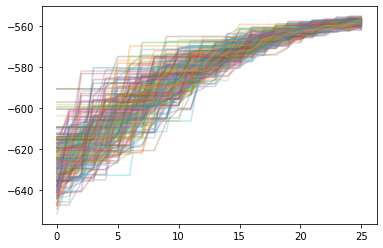

In [64]:
plt.plot(m.weights[5:], alpha=.3);

## Simulate with best fitting params

In [67]:
pp['Kmax'] = int(np.round(pp['Kmax']))
pp['r_dist'] = int(np.round(pp['r_dist']))
sam = bsam.SAMWrap(n_items=listlen, params=pp, rmax=8, scale_thresh=.001)
nlists = 1000
conds = ['IFR', 'DFR', 'CDFR']
rec = {}
for c in conds:
    print(c)
    rec[c] = ba.apply_to_zeros(sam.simulate(nlists, c))

IFR
DFR
CDFR


## SPC Fits

Text(0, 0.5, 'P(Recall)')

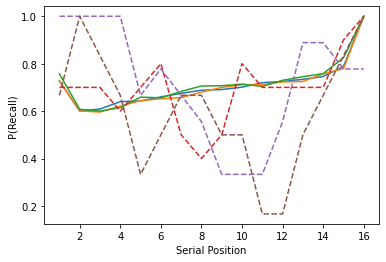

In [105]:
spc = {}
for c in rec:
    spc[c] = ba.spc(listlen=listlen, recalls=rec[c])
    plt.plot(spc[c]['serial_pos'], spc[c]['prec'])

for c in ['IFR','DFR', 'CDFR']:
    res = ba.spc(listlen=listlen, recalls=obs_recalls[c])
    plt.plot(res['serial_pos'], res['prec'], '--')
    
plt.xlabel('Serial Position')
plt.ylabel('P(Recall)')

Text(0, 0.5, 'Cond. Resp. Prob.')

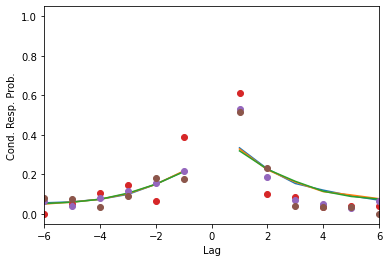

In [107]:
crp = {}
for c in rec:
    crp[c] = ba.crp(listlen=listlen, recalls=rec[c])
    plt.plot(crp[c]['lag'], crp[c]['crp'], '-')

for c in ['IFR','DFR', 'CDFR']:
    res = ba.crp(listlen=listlen, recalls=obs_recalls[c])
    plt.plot(res['lag'], res['crp'], 'o')
plt.xlim(-6, 6)
plt.xlabel('Lag')
plt.ylabel('Cond. Resp. Prob.')

## Fit TCM

In [115]:
import btcm

default_params = {
        # assoc
        'rho': .5,
        'rho_dist': None,
        'rho_ret': None,
        'beta': .5,
        'phi': 2.0,
        'gamma': .5,
        'lambda': 0.5,
        'alpha': 1.0,

        # retrieval (recall)
        'sigma_base': 0.0,
        'sigma_exp': 4.0,
        'Kmax': 30,
        'tau': 1.0,
        'xi': .0001
 }

def like_fun(pop, *args):
    # call each particle in parallel
    param_names = pop.dtype.names
    recalls = args[0]

    # loop over pop and eval the likes
    likes = np.zeros(len(pop))

    for i,p in enumerate(pop):
        # set up the params
        params = default_params.copy()
        params.update(dict(zip(param_names, p)))
        params.update({'Kmax': int(np.round(params['Kmax']))})
        #p = params
        
        # set up the model
        tcm = btcm.TCM(listlen=listlen, params=params, scale_thresh=.001)
        
        # loop over all recall types
        for list_type in recalls.keys():
            # must reset the model before presenting a list
            tcm.reset()
            
            # present the list
            tcm.present_list(list_type=list_type)
            
            # loop over recalls for each list
            for recs in recalls[list_type]:
                these_likes = tcm.calc_list_like(recs)
                likes[i] += np.log(these_likes).sum()
            
            # break early if we have a bad like
            if likes[i] == -np.inf:
                break
            
    return likes

In [112]:
# set up params
mode = 1.0
std = .75
mu = np.log(mode) + std**2

kmode = 30
kstd = .5
kmu = np.log(kmode) + kstd**2

params = [Param(name='rho', prior=dists.normal(0, 1.4),
                 transform=lambda x: dists.invlogit(x)),
          Param(name='rho_dist', prior=dists.normal(0, 1.4),
                 transform=lambda x: dists.invlogit(x)),
          Param(name='rho_ret', prior=dists.normal(0, 1.4),
                 transform=lambda x: dists.invlogit(x)),
          Param(name='beta', prior=dists.normal(0, 1.4),
                 transform=lambda x: dists.invlogit(x)),
          Param(name='lambda', prior=dists.normal(0, 1.4),
                 transform=lambda x: dists.invlogit(x)),
          Param(name='gamma', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),        
          Param(name='alpha', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),         
          Param(name='phi', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),         
          Param(name='tau', prior=dists.normal(mu, std),
                 transform=lambda x: np.exp(x)),         
          Param(name='Kmax', prior=dists.normal(kmu, kstd),
                 transform=lambda x: np.exp(x)), 
            ]

pnames = [p.name for p in params]
m = Model(s, params=params,
          like_fun=like_fun,
          like_args=(obs_recalls,),
          #num_chains = num_chains,
          #init_multiplier=1,
          verbose=True,
          pop_parallel=True
         )


In [117]:
times = m.sample(20, burnin=True)

Iterations (20):


In [120]:
save_results('tcm_bestfits_%s.pickle.gz'%s, m, burnin=10)

In [118]:
print("Best fitting params:")
burnin=5
best_ind = m.log_likes[burnin:].argmax()
print("Weight:", m.log_likes[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -496.8939584162173
"rho": 0.693844,
"rho_dist": 0.831275,
"rho_ret": 0.272772,
"beta": 0.788149,
"lambda": 0.605949,
"gamma": 2.042598,
"alpha": 2.648651,
"phi": 1.243468,
"tau": 2.632234,
"Kmax": 29.200692,


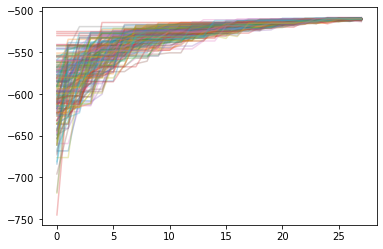

In [119]:
plt.plot(m.weights[3:], alpha=.3);

## Simulate with Best Fitting params

In [121]:
pp['Kmax'] = int(np.round(pp['Kmax']))
tcm = btcm.TCM(listlen=listlen, params=pp, scale_thresh=.001)
nlists = 1000
conds = ['IFR', 'DFR', 'CDFR']
rec = {}
for c in conds:
    print(c)
    rec[c] = ba.apply_to_zeros(tcm.simulate(nlists, c))

IFR
DFR
CDFR


## Serial Position Curve Fits

Text(0, 0.5, 'P(Recall)')

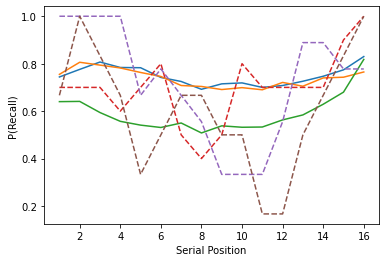

In [122]:
spc = {}
for c in rec:
    spc[c] = ba.spc(listlen=listlen, recalls=rec[c])
    plt.plot(spc[c]['serial_pos'], spc[c]['prec'])

for c in ['IFR','DFR', 'CDFR']:
    res = ba.spc(listlen=listlen, recalls=obs_recalls[c])
    plt.plot(res['serial_pos'], res['prec'], '--')
    
plt.xlabel('Serial Position')
plt.ylabel('P(Recall)')

## CRP Fits

Text(0, 0.5, 'Cond. Resp. Prob.')

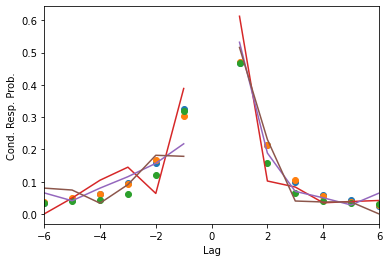

In [123]:
crp = {}
for c in rec:
    crp[c] = ba.crp(listlen=listlen, recalls=rec[c])
    plt.plot(crp[c]['lag'], crp[c]['crp'], 'o')

for c in ['IFR','DFR', 'CDFR']:
    res = ba.crp(listlen=listlen, recalls=obs_recalls[c])
    plt.plot(res['lag'], res['crp'])
plt.xlim(-6, 6)
plt.xlabel('Lag')
plt.ylabel('Cond. Resp. Prob.')

## Overall Results (Run on Rivanna Cluster)

![](./figs/SPC.png)

![](./figs/CRP.png)

# Next Week

## Reinforcement Learning!!! 

***Mini-project on confidence in LBA is due on Sunday by midnight!***